<a href="https://colab.research.google.com/github/Rashmika-Prabhode/Flutter-auto-complete/blob/main/Emotion_Recondition_model_implementaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# **Loading the data**

In [5]:
def load_dataset(filepath):
    data = []
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            data.append(line.strip().split(";"))
    return pd.DataFrame(data, columns = ["text", "emotion"])

In [6]:
train_data = load_dataset("/content/train.txt")
validation_data = load_dataset("/content/val.txt")
test_data = load_dataset("/content/test.txt")

In [7]:
df = pd.concat([train_data, validation_data, test_data])
df

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


# **Data preprocessing**

In [8]:
df = df[df['emotion'] != 'surprise']

In [9]:
df['emotion'] = df['emotion'].replace({'joy': 'happy'})
df['emotion'] = df['emotion'].replace({'sadness': 'sad'})
df['emotion'] = df['emotion'].replace({'anger': 'stress', 'fear': 'stress'})


In [10]:
df

,text,emotion
0,i didnt feel humiliated,sad
1,i can go from feeling so hopeless to so damned...,sad
2,im grabbing a minute to post i feel greedy wrong,stress
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,stress
...,...,...
1995,i just keep feeling like someone is being unki...,stress
1996,im feeling a little cranky negative after this...,stress
1997,i feel that i am useful to my people and that ...,happy
1998,im feeling more comfortable with derby i feel ...,happy


In [11]:
df.shape

(19281, 2)

In [12]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
stopwords = set(stopwords.words("english"))

df['processed_text'] = df['text'].apply(lambda text: ' '.join([stemmer.stem(lemmatizer.lemmatize(word)) for word in nltk.word_tokenize(text) if word.lower() not in stopwords]))
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,emotion,processed_text
0,i didnt feel humiliated,sad,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sad,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,stress,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,stress,feel grouchi
...,...,...,...
1995,i just keep feeling like someone is being unki...,stress,keep feel like someon unkind wrong think get b...
1996,im feeling a little cranky negative after this...,stress,im feel littl cranki negat doctor appoint
1997,i feel that i am useful to my people and that ...,happy,feel use peopl give great feel achiev
1998,im feeling more comfortable with derby i feel ...,happy,im feel comfort derbi feel though start step s...


In [13]:
df = df.drop("text", axis=1)
print(df.columns)

Index(['emotion', 'processed_text'], dtype='object')


In [14]:
df.isnull().sum()

emotion           0
processed_text    0
dtype: int64

In [15]:
df.duplicated().sum()

168

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         19113 non-null  object
 1   processed_text  19113 non-null  object
dtypes: object(2)
memory usage: 448.0+ KB


# **Data set analysis**

In [ ]:

happy_count = (df['emotion'] == 'happy').sum()
print("Number of 'happy' emotions:", happy_count)

sad_count = (df['emotion'] == 'sad').sum()
print("Number of 'sad' emotions:", sad_count)

stress_count = (df['emotion'] == 'stress').sum()
print("Number of 'stress' emotions:", stress_count)

Number of 'happy' emotions: 6713
Number of 'sad' emotions: 5737
Number of 'stress' emotions: 5031


In [ ]:
df.shape

(19113, 2)

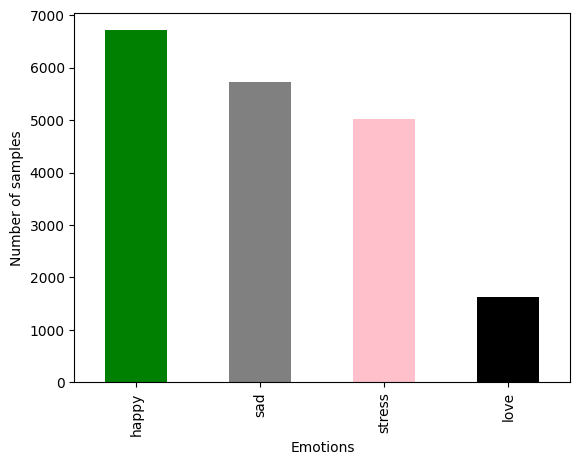

In [ ]:
df['emotion'].value_counts().plot(kind='bar', color=['green', 'gray', 'pink', 'black', 'red', 'orange'])
plt.xlabel('Emotions')
plt.ylabel('Number of samples')
plt.show()

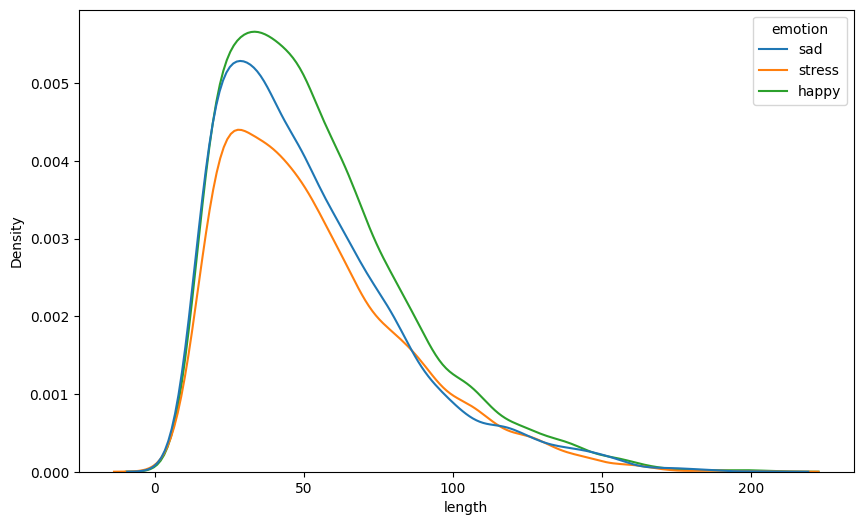

In [ ]:
df['length'] = df.processed_text.apply(lambda x:len(x))
fig = plt.figure(figsize=(10,6))
sns.kdeplot(x=df['length'], hue=df["emotion"])
plt.show()

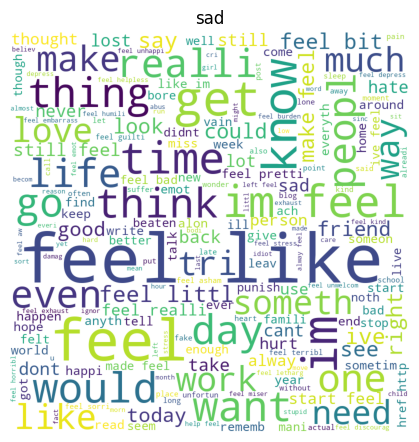

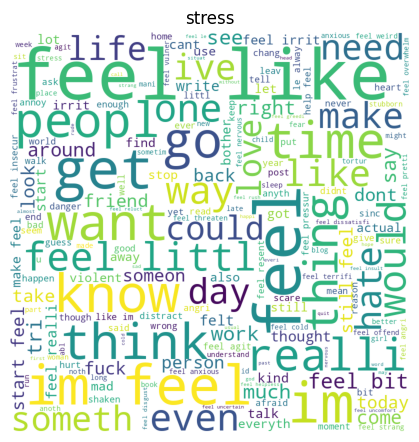

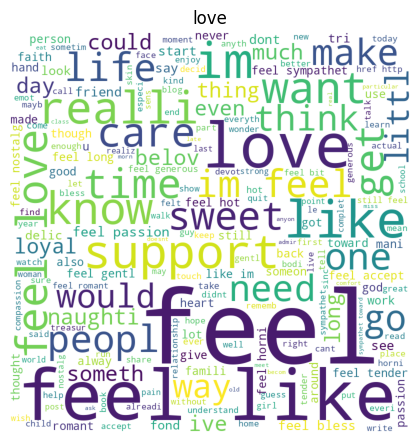

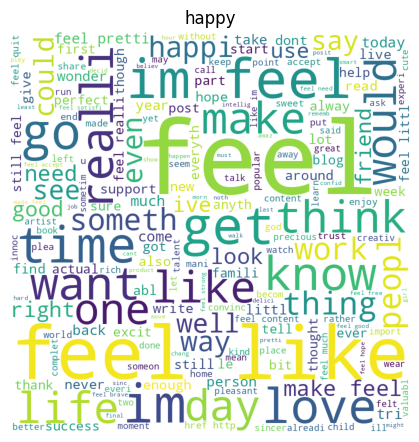

In [ ]:
emotions = df['emotion'].unique()
for emotion in emotions:
    processed_text = " ".join(df[df['emotion'] == emotion]['processed_text'])
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(processed_text)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(emotion)
    plt.show()

# **Modeling**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df["processed_text"], df["emotion"], test_size=0.2, random_state=42)

In [19]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

**Random forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=100)
rf.fit(X_train_cv, y_train)

NameError: ignored

In [ ]:
y_pred_rf = rf.predict(X_test_cv)

In [ ]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification report of Random Forest classifier:\n", report_rf)

Classification report of Random Forest classifier:
               precision    recall  f1-score   support

       happy       0.96      0.93      0.94      1342
         sad       0.89      0.93      0.91      1131
      stress       0.90      0.91      0.91      1024

    accuracy                           0.92      3497
   macro avg       0.92      0.92      0.92      3497
weighted avg       0.92      0.92      0.92      3497



**Logistic regression**

In [20]:
lr = LogisticRegression(max_iter=1000, random_state=100)
lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=1000, random_state=100)

In [21]:
y_pred_lr = lr.predict(X_test_cv)

In [22]:
report_lr = classification_report(y_test, y_pred_lr)
print("Classification report of Logistic Regression (Multi-Class):\n", report_lr)

Classification report of Logistic Regression (Multi-Class):
               precision    recall  f1-score   support

       happy       0.87      0.90      0.89      1311
        love       0.79      0.68      0.73       338
         sad       0.88      0.92      0.90      1170
      stress       0.91      0.87      0.89      1004

    accuracy                           0.88      3823
   macro avg       0.86      0.84      0.85      3823
weighted avg       0.88      0.88      0.88      3823



**Naive Bayes**

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = nb.predict(X_test_cv)

In [ ]:
report_nb = classification_report(y_test, y_pred_nb)
print("Classification report of Multinomial Naive Bayes:\n", report_nb)

Classification report of Multinomial Naive Bayes:
               precision    recall  f1-score   support

       happy       0.92      0.92      0.92      1342
         sad       0.86      0.90      0.88      1131
      stress       0.89      0.83      0.86      1024

    accuracy                           0.89      3497
   macro avg       0.89      0.89      0.89      3497
weighted avg       0.89      0.89      0.89      3497



**SVM**

In [ ]:
svm = LinearSVC(random_state=100)
svm.fit(X_train_cv, y_train)

LinearSVC(random_state=100)

In [ ]:
y_pred_svm = svm.predict(X_test_cv)

In [ ]:
report_svm = classification_report(y_test, y_pred_svm)
print("Classification report of Linear SVM:\n", report_svm)

Classification report of Linear SVM:
               precision    recall  f1-score   support

       happy       0.94      0.94      0.94      1342
         sad       0.88      0.91      0.90      1131
      stress       0.91      0.88      0.90      1024

    accuracy                           0.91      3497
   macro avg       0.91      0.91      0.91      3497
weighted avg       0.91      0.91      0.91      3497



**LSTM**

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
emotions = le.classes_

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=32, input_length=max_len))
model.add(LSTM(32))
model.add(Dense(len(emotions), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train_padded, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
350/350 [==============================] - 13s 29ms/step - loss: 0.9044 - accuracy: 0.5110 - val_loss: 0.6588 - val_accuracy: 0.6593
Epoch 2/30
350/350 [==============================] - 8s 23ms/step - loss: 0.5565 - accuracy: 0.6913 - val_loss: 0.6077 - val_accuracy: 0.6965
Epoch 3/30
350/350 [==============================] - 9s 27ms/step - loss: 0.4385 - accuracy: 0.8035 - val_loss: 0.4792 - val_accuracy: 0.8237
Epoch 4/30
350/350 [==============================] - 8s 22ms/step - loss: 0.2168 - accuracy: 0.9326 - val_loss: 0.2691 - val_accuracy: 0.9131
Epoch 5/30
350/350 [==============================] - 9s 27ms/step - loss: 0.1015 - accuracy: 0.9703 - val_loss: 0.2768 - val_accuracy: 0.9167
Epoch 6/30
350/350 [==============================] - 9s 26ms/step - loss: 0.0648 - accuracy: 0.9828 - val_loss: 0.2671 - val_accuracy: 0.9246
Epoch 7/30
350/350 [==============================] - 8s 23ms/step - loss: 0.0511 - accuracy: 0.9852 - val_loss: 0.2960 - val_accuracy: 0.928

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=emotions)
print("Accuracy:", accuracy)
print("Classification report of LSTM:\n", report)

110/110 [==============================] - 1s 6ms/step
Accuracy: 0.912782384901344
Classification report of LSTM:
               precision    recall  f1-score   support

       happy       0.96      0.92      0.94      1342
         sad       0.88      0.91      0.90      1131
      stress       0.89      0.90      0.89      1024

    accuracy                           0.91      3497
   macro avg       0.91      0.91      0.91      3497
weighted avg       0.91      0.91      0.91      3497



# **Testing the model model**

In [23]:
import joblib

In [24]:
joblib.dump(lr, "lr_model")

['lr_model']

In [25]:
modellr = joblib.load("lr_model")

In [26]:
modellr

LogisticRegression(max_iter=1000, random_state=100)

In [27]:
predicted = modellr.predict(X_test_cv)
import pandas as pd
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted})
print(results_df)

       Actual Predicted
6847    happy     happy
9800      sad       sad
15981   happy     happy
6781    happy     happy
4424      sad       sad
...       ...       ...
12883    love      love
139       sad      love
4436      sad       sad
2160   stress    stress
1585    happy     happy

[3823 rows x 2 columns]


In [28]:
modellr.predict(X_test_cv)

array(['happy', 'sad', 'happy', ..., 'sad', 'stress', 'happy'],
      dtype=object)

# **Converting the emoji to text**

In [64]:
emoji = 'full_emoji.csv'
df = pd.read_csv(emoji, encoding='utf-8')
print(df.head(20))

   emoji                             name
0      😀                    grinning face
1      😃      grinning face with big eyes
2      😄  grinning face with smiling eyes
3      😁   beaming face with smiling eyes
4      😆          grinning squinting face
5      😅         grinning face with sweat
6      🤣    rolling on the floor laughing
7      😂           face with tears of joy
8      🙂            slightly smiling face
9      🙃                 upside-down face
10     😉                     winking face
11     😊   smiling face with smiling eyes
12     😇           smiling face with halo
13     🥰         smiling face with hearts
14     😍     smiling face with heart-eyes
15     🤩                      star-struck
16     😘              face blowing a kiss
17     😗                     kissing face
18     ☺                     smiling face
19     😚    kissing face with closed eyes


In [ ]:
# pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
# හෙට හමුවෙමු 🙂
# හෙට හමුවෙමු 😡
# 😢 😭 😞මගේ බල්ලා මැරුණා
# මම ඔයාට ආදරෙයි💓

In [ ]:
user_input = input('Enter text :')

Enter text :හෙට හමුවෙමු 😡


In [ ]:
import emoji

def convert_emoji_to_text(sentence):
    text_with_emojis_replaced = emoji.demojize(sentence)
    return text_with_emojis_replaced

if __name__ == "__main__":
    input_sentence = user_input

    output_sentence = convert_emoji_to_text(input_sentence)

    print(f"Original sentence: {input_sentence}")
    print(f"Sentence with emojis replaced: {output_sentence}")

Original sentence: හෙට හමුවෙමු 😡
Sentence with emojis replaced: හෙට හමුවෙමු :enraged_face:


# **Translation**

In [ ]:
#pip install googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator, LANGUAGES

def translate_sinhala_to_english(text):
    try:

        translator = Translator()
        detected_language = translator.detect(text).lang
        if detected_language == 'si':
            translation = translator.translate(text, src='si', dest='en')
            return translation.text
        else:
            return "Input text is not in Sinhala."

    except Exception as e:
        return str(e)

if __name__ == "__main__":

    english_translation = translate_sinhala_to_english(output_sentence)

    if english_translation:
        print(f"Original sentence: {user_input}")
        print(f"Emoji converted: {output_sentence}")
        print(f"English: {english_translation}")
    else:
        print("Translation failed.")

Original sentence: හෙට හමුවෙමු 😡
Emoji converted: හෙට හමුවෙමු :enraged_face:
English: See you tomorrow: enrod_face:


In [ ]:
import string

def remove_punctuation_and_replace(input_string):
    translator = str.maketrans('', '', string.punctuation.replace('_', ''))
    result = input_string.translate(translator)
    result = result.replace('_', ' ')
    return result

text_without_punctuation = remove_punctuation_and_replace(english_translation)

print("Original text:", english_translation)
print("Final text:", text_without_punctuation)


Original text: See you tomorrow: enrod_face:
Final text: See you tomorrow enrod face


In [ ]:
array = cv.transform([text_without_punctuation]).toarray()
pred = modellr.predict(array)
print(pred)

['happy']
